# MVP - Qualidade de Software, Segurança e Sistemas Inteligentes
Bruna Fonseca

Dataset escolhido: Classificação de cogumelos

Esse dataset possui dados de diversos cogumelos e os classifica entre comestíveis e venenosos.

O objetivo é treinar um modelo para identificar de um cogumelo é comestível ou venenoso.


### Preparando o ambiente

Nessa etapa iremos realizar todos os imports necessários para a execução do notebook

In [2]:
# configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from collections import Counter


### Carregando os dados

In [3]:
# URL de importação do dataset
url = "https://raw.githubusercontent.com/brufonseca/ml_classification/main/mushrooms2.csv"

# Importa os dados para um DataFrame
dataset = pd.read_csv(url, delimiter=',')

# Exibe as primeiras linhas do dataset
dataset.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [4]:
# Exibe um resumo do dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8111 entries, 0 to 8110
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8111 non-null   object
 1   cap-shape                 8111 non-null   object
 2   cap-surface               8111 non-null   object
 3   cap-color                 8111 non-null   object
 4   bruises                   8111 non-null   object
 5   odor                      8111 non-null   object
 6   gill-attachment           8111 non-null   object
 7   gill-spacing              8111 non-null   object
 8   gill-size                 8111 non-null   object
 9   gill-color                8111 non-null   object
 10  stalk-shape               8111 non-null   object
 11  stalk-root                8111 non-null   object
 12  stalk-surface-above-ring  8111 non-null   object
 13  stalk-surface-below-ring  8111 non-null   object
 14  stalk-color-above-ring  

In [5]:
# Exibe as estatísticas do dataset
dataset.describe(include='all')

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,8111,8111,8111,8111,8111,8111,8111,8111,8111,8111,...,8111,8111,8111,8111,8111,8111,8111,8111,8111,8111
unique,2,6,4,10,2,9,2,2,2,12,...,4,9,9,1,4,3,5,9,6,7
top,e,x,y,n,f,n,f,c,b,b,...,s,w,w,p,w,o,p,w,v,d
freq,4201,3653,3239,2275,4735,3521,7908,6800,5604,1723,...,4927,4462,4379,8111,7917,7477,3961,2381,4032,3144


#### Formato do dataset
Vamos avaliar o formato do nosso dataset

In [6]:
print("Formato Dataset", dataset.shape)

Formato Dataset (8111, 23)


### Analisando os dados

#### Verificando se dados estão faltando

Vamos verficar se alguma das colunas possui dados faltando. Em caso positivo, realizaremos o tratamento necessário

In [7]:
#Exibe quantidade de valores nulos em cada coluna
dataset.isnull().sum()

class                       0
cap-shape                   0
cap-surface                 0
cap-color                   0
bruises                     0
odor                        0
gill-attachment             0
gill-spacing                0
gill-size                   0
gill-color                  0
stalk-shape                 0
stalk-root                  0
stalk-surface-above-ring    0
stalk-surface-below-ring    0
stalk-color-above-ring      0
stalk-color-below-ring      0
veil-type                   0
veil-color                  0
ring-number                 0
ring-type                   0
spore-print-color           0
population                  0
habitat                     0
dtype: int64

#### Analisando a coluna alvo

*A coluna 'class' possui a informação se o cogumelo é comestível ou venenoso*


In [8]:
#Exibe a frequência de cada valor distinto da coluna
dataset['class'].value_counts()

class
e    4201
p    3910
Name: count, dtype: int64

In [9]:
# Exible os valores únicos da coluna
print(dataset["class"].unique())

['p' 'e']


Verificando se o dataset está balanceado

Distribuição dos tipos de cogumelo: Counter({'e': 4201, 'p': 3910})


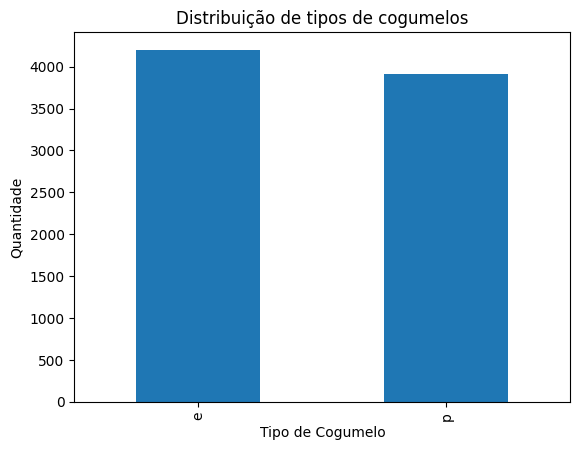

In [10]:

print("Distribuição dos tipos de cogumelo:", Counter(dataset['class']))


class_count = dataset['class'].value_counts()
class_count.plot(kind='bar', title='Distribuição de tipos de cogumelos', ylabel='Quantidade', xlabel='Tipo de Cogumelo')
plt.show()



*O dataset está balanceado*

### Preparando os dados




In [11]:
# Convertendo colunas do tipo object para category
label_encoder=LabelEncoder()

for column in dataset.columns:
  if dataset[column].dtype == 'object':
    dataset[column] = label_encoder.fit_transform(dataset[column])

dataset.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,1,5,2,4,1,6,1,0,1,4,...,2,7,7,0,2,1,4,2,3,5
1,0,5,2,9,1,0,1,0,0,4,...,2,7,7,0,2,1,4,3,2,1
2,0,0,2,8,1,3,1,0,0,5,...,2,7,7,0,2,1,4,3,2,3
3,1,5,3,8,1,6,1,0,1,5,...,2,7,7,0,2,1,4,2,3,5
4,0,5,2,3,0,5,1,1,0,4,...,2,7,7,0,2,1,0,3,0,1


*Colunas com todos os valores iguais serão eliminadas, pois não contribuem para a classificação*

In [12]:
# Verificar quais colunas possuem todos os valores iguais
cols = dataset.nunique() == 1
cols_list = dataset.columns[cols].tolist()

for col_name in cols_list:
    print(col_name, " possui todos os valores iguais e será eliminada")
    dataset=dataset.drop([col_name],axis=1)

dataset.head()

veil-type  possui todos os valores iguais e será eliminada


,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,1,5,2,4,1,6,1,0,1,4,...,2,2,7,7,2,1,4,2,3,5
1,0,5,2,9,1,0,1,0,0,4,...,2,2,7,7,2,1,4,3,2,1
2,0,0,2,8,1,3,1,0,0,5,...,2,2,7,7,2,1,4,3,2,3
3,1,5,3,8,1,6,1,0,1,5,...,2,2,7,7,2,1,4,2,3,5
4,0,5,2,3,0,5,1,1,0,4,...,2,2,7,7,2,1,0,3,0,1


### Separando os dados

In [13]:
test_size = 0.25 # tamanho do conjunto de teste
seed = 11 # semente aleatória

# Separação em conjuntos de treino e teste
X = dataset.drop(['class'], axis=1)
y = dataset["class"]

X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=test_size, shuffle=True, random_state=seed, stratify=y) # holdout com estratificação

# Parâmetros e partições da validação cruzada
scoring = 'accuracy'
n_splits = 10
kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed) # validação cruzada com estratificação



#### Modelos de Classificação

Foram escolhidos os seguintes modelos: *Regressão Logística*, *KNN*, *Árvore de Decisão*, *Naive Bayes*, *SVM* e *Random Forest*  

LR - Acurácia: 0.95 (+/- 0.01)
KNN - Acurácia: 1.00 (+/- 0.00)
CART - Acurácia: 1.00 (+/- 0.00)
NB - Acurácia: 0.93 (+/- 0.01)
SVM - Acurácia: 0.97 (+/- 0.01)
RF - Acurácia: 1.00 (+/- 0.00)


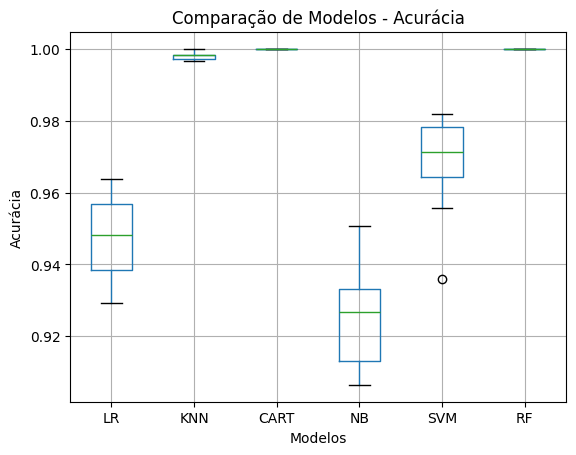

In [14]:
np.random.seed(11) # Definição de uma semente global

n_estimators = 100
max_features = 3

# Definição dos modelos de classificação
models = {
    'LR': LogisticRegression(max_iter=200, random_state=seed),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'CART': DecisionTreeClassifier(random_state=seed),
    'NB': GaussianNB(),
    'SVM': SVC(kernel='linear', random_state=seed),
    'RF': RandomForestClassifier(n_estimators=n_estimators, max_features=max_features)
}


results = []


# Avaliação dos modelos como conjunto de treinamento
for name, model in models.items():
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    mean_cv_score = np.mean(cv_results)
    results.append((name, cv_results))
    print(f'{name} - Acurácia: {cv_results.mean():.2f} (+/- {cv_results.std():.2f})')

# Boxplot de comparação dos modelos
results_df = pd.DataFrame({name: scores for name, scores in results})
results_df.boxplot()
plt.title('Comparação de Modelos - Acurácia')
plt.ylabel('Acurácia')
plt.xlabel('Modelos')
plt.show()

#### Padronização e normalização dos dados

In [15]:
np.random.seed(11) # Definição de uma semente global

n_estimators = 100
max_features = 3

# Definição dos modelos de classificação
models = {
    'LR': LogisticRegression(max_iter=200, random_state=seed),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'CART': DecisionTreeClassifier(random_state=seed),
    'NB': GaussianNB(),
    'SVM': SVC(kernel='linear', random_state=seed),
    'RF': RandomForestClassifier(n_estimators=n_estimators, max_features=max_features)
}


# Definição dos pipelines de normalização
pipelines = {
    'Standard Scaling': StandardScaler(),
    'MinMax Scaling': MinMaxScaler()
}

# Treinamento e avaliação dos modelos com pipelines de normalização
for scale_name, scaler in pipelines.items():
    print(f"\nPipeline de {scale_name}:\n")
    for model_name, model in models.items():
        pipeline = Pipeline([
            ('scaler', scaler),
            ('classifier', model)
        ])

        scores = cross_val_score(pipeline, X_train, y_train, cv=kfold, scoring='accuracy')
        results.append((model_name + "-" + scale_name, scores))

        print(f"{model_name} - Acurácia: {scores.mean():.2f}, Desvio Padrão: {scores.std():.2f}")





Pipeline de Standard Scaling:

LR - Acurácia: 0.95, Desvio Padrão: 0.01
KNN - Acurácia: 1.00, Desvio Padrão: 0.00
CART - Acurácia: 1.00, Desvio Padrão: 0.00
NB - Acurácia: 0.93, Desvio Padrão: 0.01
SVM - Acurácia: 0.98, Desvio Padrão: 0.01
RF - Acurácia: 1.00, Desvio Padrão: 0.00

Pipeline de MinMax Scaling:

LR - Acurácia: 0.95, Desvio Padrão: 0.01
KNN - Acurácia: 1.00, Desvio Padrão: 0.00
CART - Acurácia: 1.00, Desvio Padrão: 0.00
NB - Acurácia: 0.93, Desvio Padrão: 0.01
SVM - Acurácia: 0.94, Desvio Padrão: 0.01
RF - Acurácia: 1.00, Desvio Padrão: 0.00


In [ ]:
# Pipeline de Standard Scaling:

# LR - Acurácia: 0.95, Desvio Padrão: 0.01
# KNN - Acurácia: 1.00, Desvio Padrão: 0.00
# CART - Acurácia: 1.00, Desvio Padrão: 0.00
# NB - Acurácia: 0.93, Desvio Padrão: 0.01
# SVM - Acurácia: 0.98, Desvio Padrão: 0.01
# RF - Acurácia: 1.00, Desvio Padrão: 0.00

# Pipeline de MinMax Scaling:

# LR - Acurácia: 0.95, Desvio Padrão: 0.01
# KNN - Acurácia: 1.00, Desvio Padrão: 0.00
# CART - Acurácia: 1.00, Desvio Padrão: 0.00
# NB - Acurácia: 0.93, Desvio Padrão: 0.01
# SVM - Acurácia: 0.94, Desvio Padrão: 0.01
# RF - Acurácia: 1.00, Desvio Padrão: 0.00

#### Otimização dos hiperparâmetros

In [16]:
np.random.seed(11) # Definição de uma semente global

# Definição dos modelos e dos espaços de hiperparâmetros para Grid Search
param_grids = {
    'Naive Bayes': {
        'classifier': [GaussianNB()],
        'classifier__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
    },
    'KNN': {
        'classifier': [KNeighborsClassifier()],
        'classifier__n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21],
        'classifier__weights': ['uniform', 'distance'],
        'classifier__metric': ["euclidean", "manhattan", "minkowski"]
    },
    'Logistic Regression': {
        'classifier': [LogisticRegression(max_iter=1000)],
        'classifier__C': [0.1, 1, 10,100],
        'classifier__penalty': ['l1', 'l2', 'elasticnet', 'none'],
        'classifier__solver': ['newton-cg', 'lbfgs', 'liblinear', 'saga']
    },
    'Decision Tree': {
        'classifier': [DecisionTreeClassifier()],
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__max_depth': [None, 5, 10, 15],
        'classifier__min_samples_split': [2, 5, 10]
    },
    'Random Forest': {
        'classifier': [RandomForestClassifier()],
        'classifier__n_estimators': [10, 50, 100, 150],
        'classifier__max_depth': [None, 5, 10, 20],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__max_features': ['auto', 'sqrt', 'log2'],
        'classifier__min_samples_leaf': [1, 2, 4]
    },
    'SVM': {
        'classifier': [SVC()],
        'classifier__C': [0.1, 1, 10, 100],
        'classifier__kernel': ['linear', 'rbf'],
        'classifier__gamma': [1, 0.1, 0.01, 0.001]

    }
}

# Dicionário para armazenar os melhores modelos e suas performances
selected_models = {}

# Realização do Grid Search para cada modelo
for model_name, param_grid in param_grids.items():
    print(f"\nOtimização de hiperparâmetros para {model_name}...\n")

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', param_grid['classifier'][0])  # Inicializar o classificador
    ])

    grid_search = GridSearchCV(pipeline, param_grid, cv=kfold, scoring=scoring, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    selected_models[model_name] = {
        'best_estimator': grid_search.best_estimator_,
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_
    }

    print(f"Melhores parâmetros para {model_name}: {grid_search.best_params_}")
    print(f"Melhor acurácia para {model_name}: {grid_search.best_score_:.2f}")

#Execução demorou 36 minutos



Otimização de hiperparâmetros para Naive Bayes...

Melhores parâmetros para Naive Bayes: {'classifier': GaussianNB(), 'classifier__var_smoothing': 1e-09}
Melhor acurácia para Naive Bayes: 0.93

Otimização de hiperparâmetros para KNN...

Melhores parâmetros para KNN: {'classifier': KNeighborsClassifier(), 'classifier__metric': 'euclidean', 'classifier__n_neighbors': 1, 'classifier__weights': 'uniform'}
Melhor acurácia para KNN: 1.00

Otimização de hiperparâmetros para Logistic Regression...

Melhores parâmetros para Logistic Regression: {'classifier': LogisticRegression(max_iter=1000), 'classifier__C': 100, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}
Melhor acurácia para Logistic Regression: 0.97

Otimização de hiperparâmetros para Decision Tree...

Melhores parâmetros para Decision Tree: {'classifier': DecisionTreeClassifier(), 'classifier__criterion': 'gini', 'classifier__max_depth': None, 'classifier__min_samples_split': 2}
Melhor acurácia para Decision Tree: 1.00

O

In [ ]:
""" Otimização de hiperparâmetros para Naive Bayes...

Melhores parâmetros para Naive Bayes: {'classifier': GaussianNB(), 'classifier__var_smoothing': 1e-09}
Melhor acurácia para Naive Bayes: 0.93

Otimização de hiperparâmetros para KNN...

Melhores parâmetros para KNN: {'classifier': KNeighborsClassifier(), 'classifier__metric': 'euclidean', 'classifier__n_neighbors': 1, 'classifier__weights': 'uniform'}
Melhor acurácia para KNN: 1.00

Otimização de hiperparâmetros para Logistic Regression...

Melhores parâmetros para Logistic Regression: {'classifier': LogisticRegression(max_iter=1000), 'classifier__C': 100, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}
Melhor acurácia para Logistic Regression: 0.97

Otimização de hiperparâmetros para Decision Tree...

Melhores parâmetros para Decision Tree: {'classifier': DecisionTreeClassifier(), 'classifier__criterion': 'gini', 'classifier__max_depth': None, 'classifier__min_samples_split': 2}
Melhor acurácia para Decision Tree: 1.00

Otimização de hiperparâmetros para Random Forest...

Melhores parâmetros para Random Forest: {'classifier': RandomForestClassifier(), 'classifier__max_depth': None, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 10}
Melhor acurácia para Random Forest: 1.00
...
Otimização de hiperparâmetros para SVM...

Melhores parâmetros para SVM: {'classifier': SVC(), 'classifier__C': 1, 'classifier__gamma': 0.1, 'classifier__kernel': 'rbf'}
Melhor acurácia para SVM: 1.00 """

#### Finalização do Modelo

Os melhores resultados foram observados para os modelos: *KNN*, *Decision Tree*,*Random Forest* e *SVM*

In [ ]:
# Melhores parâmetros para KNN: {'classifier': KNeighborsClassifier(), 'classifier__metric': 'euclidean', 'classifier__n_neighbors': 1, 'classifier__weights': 'uniform'}
# Melhor acurácia média para KNN: 1.00

# Melhores parâmetros para Decision Tree: {'classifier': DecisionTreeClassifier(), 'classifier__criterion': 'gini', 'classifier__max_depth': None, 'classifier__min_samples_split': 2}
# Melhor acurácia média para Decision Tree: 1.00

# Melhores parâmetros para Random Forest: {'classifier': RandomForestClassifier(), 'classifier__max_depth': None, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 10}
# Melhor acurácia média para Random Forest: 1.00

# Melhores parâmetros para SVM: {'classifier': SVC(), 'classifier__C': 1, 'classifier__gamma': 0.1, 'classifier__kernel': 'rbf'}
# Melhor acurácia média para SVM: 1.00

In [17]:
# Melhores parâmetros para Decision Tree: {'classifier': DecisionTreeClassifier(), 'classifier__criterion': 'gini', 'classifier__max_depth': None, 'classifier__min_samples_split': 2}
# Melhor acurácia média para Decision Tree: 1.00

# Avaliando com o Decision Tree

np.random.seed(11)

# Preparação do modelo
scaler = MinMaxScaler().fit(X_train)
rescaledX = scaler.transform(X_train) # aplicação da normalização no conjunto de treino
model = DecisionTreeClassifier(criterion='gini',max_depth=None, min_samples_split=2)
model.fit(rescaledX, y_train)

# Estimativa da acurácia no conjunto de teste
rescaledTestX = scaler.transform(X_test) # aplicação da normalização no conjunto de teste
predictions = model.predict(rescaledTestX)
print(accuracy_score(y_test, predictions))

1.0


##### Rodando o modelo a partir de um pipeline com os hiperparâmetros otimizados.

In [18]:
np.random.seed(11)

model = DecisionTreeClassifier(criterion='gini',max_depth=None, min_samples_split=2)

pipeline = Pipeline(steps=[('MinMaxScaler', MinMaxScaler()), ('KNN', model)])

pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)
print(accuracy_score(y_test, predictions))

1.0


##### Salvando os arquivos

In [19]:
# Salvando o modelo
model_filename = 'dt_mushroom_classifier.pkl'
with open("../models/"+model_filename, 'wb') as file:
    pickle.dump(model, file)

# Salvando o scaler
scaler_filename = 'minmax_scaler_mushroom.pkl'
with open("../scalers/"+scaler_filename, 'wb') as file:
    pickle.dump(scaler, file)

# Salvando o pipeline
pipeline_filename = 'dt_mushroom_pipeline.pkl'
with open("../pipelines/"+pipeline_filename, 'wb') as file:
    pickle.dump(pipeline, file)

# Salvando X_test e y_test
X_test_df = pd.DataFrame(X_test, columns=dataset.columns[1:])
y_test_df = pd.DataFrame(y_test, columns=[dataset.columns[0]])
X_test_df.to_csv("../data/X_test_dataset_mushroom.csv", index=False)
y_test_df.to_csv("../data/y_test_dataset_mushroom.csv", index=False)


##### Simulando a aplicação do modelo em dados não vistos

In [20]:
scaler = MinMaxScaler().fit(X) 
rescaledX = scaler.transform(X)
model.fit(rescaledX, y)

DecisionTreeClassifier()

In [21]:
data = {'cap-shape':[2,3],
        'cap-surface':[2,2],
        'cap-color':[4,2],
        'bruises':[0,0],
        'odor':[5,7],
        'gill-attachment':[0,1],
        'gill-spacing':[0,0],
        'gill-size':[0,1],
        'gill-color':[6,0],
        'stalk-shape':[0,1],
        'stalk-root':[0,0],
        'stalk-surface-above-ring':[2,2],
        'stalk-surface-below-ring':[2,2],
        'stalk-color-above-ring':[5,6],
        'stalk-color-below-ring':[5,7],
        'veil-color':[1,2],
        'ring-number':[1,1],
        'ring-type':[4,0],
        'spore-print-color':[4,7],
        'population':[1,4],
        'habitat':[2,4]
      }

atributos = ['cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
       'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
       'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
       'stalk-surface-below-ring', 'stalk-color-above-ring',
       'stalk-color-below-ring', 'veil-color', 'ring-number', 'ring-type',
       'spore-print-color', 'population', 'habitat']


entrada = pd.DataFrame(data, columns=atributos)

X_entrada = entrada[:]

# Padronização nos dados de entrada usando o scaler utilizado em X
rescaledEntradaX = scaler.transform(X_entrada)
print(rescaledEntradaX)

NameError: name 'array_entrada' is not defined

In [ ]:
# Predição de classes dos dados de entrada
saidas = model.predict(rescaledEntradaX)
print(saidas)